In [163]:
import glob
import matplotlib.pyplot as plt
import os
import re
import imageio.v2 as imageio
import numpy as np
import pandas as pd
import boto3

In [131]:
# Inputs
transaction_ID = '200009'


In [132]:
# Function to extract the numeric value from filenames
def extract_row_col(filepath):
    match = re.findall(r'(\d+)', os.path.basename(filepath))  # Find all numbers in filename
    if len(match) >= 3:
        return (int(match[1]), int(match[2]))  # Use second and third numbers (row, col)
    return (9999, 9999)  # Default large number to push problematic files to the end

# Get all the input images and sort them numerically
folder_data_input = sorted(
    glob.glob(os.path.join(os.path.expanduser("~"), "satellite-ml-solarp-detection","acquisition", transaction_ID, "*tif")),
    key= extract_row_col
)

folder_data_preds = sorted(
    glob.glob(os.path.join(os.path.expanduser("~"), "satellite-ml-solarp-detection","prediction", transaction_ID, "*tif")),
    key= extract_row_col
)


In [133]:
input_image_paths = folder_data_input[:]
preds_image_paths = folder_data_preds[:]

print(input_image_paths)
print(120*"-")
print(f'Number of files in the acquisition ID "{transaction_ID}": {len(input_image_paths)}')


['/home/sagemaker-user/satellite-ml-solarp-detection/acquisition/200009/200009_000_000.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/acquisition/200009/200009_000_001.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/acquisition/200009/200009_000_002.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/acquisition/200009/200009_000_003.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/acquisition/200009/200009_001_000.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/acquisition/200009/200009_001_001.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/acquisition/200009/200009_001_002.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/acquisition/200009/200009_001_003.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/acquisition/200009/200009_002_000.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/acquisition/200009/200009_002_001.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/acquisition/200009/200009_0

In [134]:
print(preds_image_paths)
print(120*"-")
print(f'Number of files in the acquisition ID "{transaction_ID}": {len(preds_image_paths)}')

['/home/sagemaker-user/satellite-ml-solarp-detection/prediction/200009/pred_200009_000_000.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/prediction/200009/pred_200009_000_001.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/prediction/200009/pred_200009_000_002.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/prediction/200009/pred_200009_000_003.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/prediction/200009/pred_200009_001_000.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/prediction/200009/pred_200009_001_001.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/prediction/200009/pred_200009_001_002.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/prediction/200009/pred_200009_001_003.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/prediction/200009/pred_200009_002_000.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/prediction/200009/pred_200009_002_001.tif', '/home/sagemaker-user/satellite-ml-sola

In [135]:
# Determine the the grid size
nb_of_rows = int(input_image_paths[-1][-11:-8]) + 1
nb_of_cols = int(input_image_paths[-1][-7:-4]) + 1

print(f'Grid shape: {nb_of_rows} rows by {nb_of_cols} cols.')



Grid shape: 4 rows by 4 cols.


In [158]:
# Generate Report (Mosaic Display)
def plot_mosaic(image_paths, title, nb_of_rows, nb_of_cols):
    fig, axes = plt.subplots(nb_of_rows, nb_of_cols, figsize=(12, 12))
    axes = axes.ravel()
    
    for idx, img_path in enumerate(image_paths):
        img = imageio.imread(img_path).astype(np.float32)
        
        # acquisition 4 band images 
        if len(img.shape) == 3:
            if img.shape[-1] == 4:  # Check if the image has 4 bands
                img = np.stack([img[:, :, 0], img[:, :, 1], img[:, :, 2]], axis=-1)  # Use only RGB bands
            img = (img.astype(np.float32) - np.min(img)) / (np.max(img) - np.min(img)) if np.max(img) > 1 else img.astype(np.float32)
        
        # predictions 1 band images
        else:
            img = img.astype(np.uint8)
            
            
        axes[idx].imshow(img, cmap="gray")
        #axes[idx].set_title(f"{title} {idx+1}")
        axes[idx].axis("off")

    plt.subplots_adjust(wspace=-0.01, hspace=-0.01)
    #plt.tight_layout()
    image_path = os.path.join(os.path.expanduser("~"), "satellite-ml-solarp-detection", "reports", transaction_ID, f'{title}.png')
    plt.savefig(image_path, bbox_inches='tight', dpi=300)
    print(f"Saved mosaic: {image_path}")
    plt.show()

    return image_path


Saved mosaic: /home/sagemaker-user/satellite-ml-solarp-detection/reports/200009/input.png


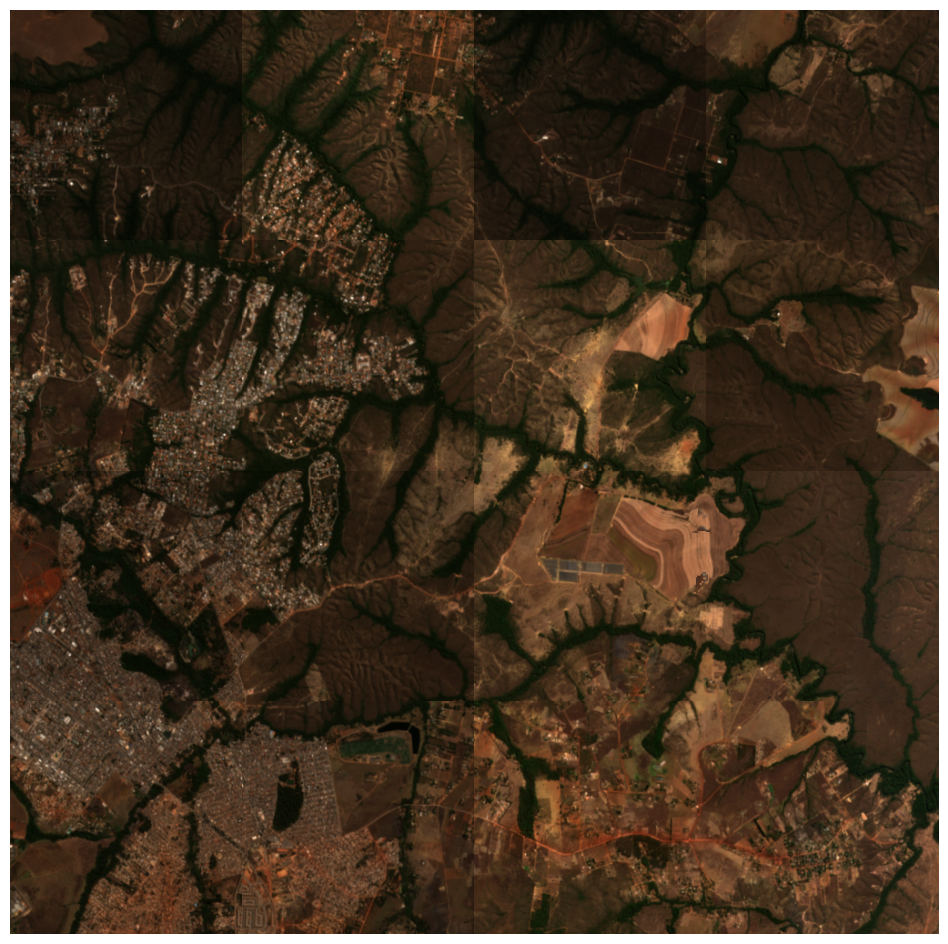

In [160]:
# Plot input and prediction mosaics
input_mosaic_path = plot_mosaic(input_image_paths, "input", nb_of_rows, nb_of_cols)

Saved mosaic: /home/sagemaker-user/satellite-ml-solarp-detection/reports/200009/prediction.png


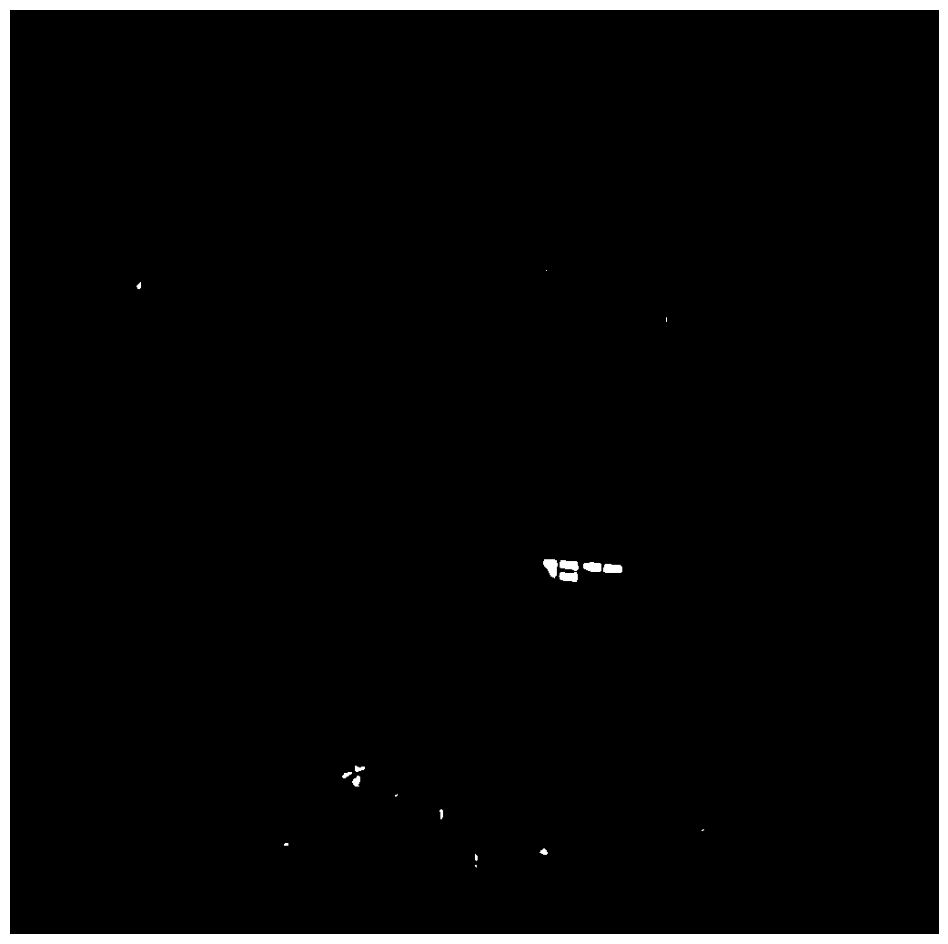

In [161]:
# Plot input and prediction mosaics
pred_mosaic_path =  plot_mosaic(preds_image_paths, "prediction", nb_of_rows, nb_of_cols)

-----


In [154]:
# Compute Statistics
def compute_statistics(predicted_paths):
    stats = []
    for path in predicted_paths:
        pred_img = imageio.imread(path)
        total_pixels = pred_img.size
        positive_pixels = np.sum(pred_img > 0)
        coverage_percentage = (positive_pixels / total_pixels) * 100
        stats.append({
            "File": os.path.basename(path),
            "Total Pixels": total_pixels,
            "Positive Pixels": positive_pixels,
            "Coverage %": coverage_percentage
        })
    return pd.DataFrame(stats)

stats_df = compute_statistics(preds_image_paths)
print(stats_df)

# Save the report as a CSV
report_path = os.path.join(os.path.expanduser("~"), "satellite-ml-solarp-detection", "reports",transaction_ID, "stats.csv")
os.makedirs(os.path.dirname(report_path), exist_ok=True)
stats_df.to_csv(report_path, index=False)
print(f"Report saved: {report_path}")


/tmp/ipykernel_916/428506732.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  positive_pixels = np.sum(pred_img > 0)


                       File  Total Pixels  Positive Pixels  Coverage %
0   pred_200009_000_000.tif         65536                0    0.000000
1   pred_200009_000_001.tif         65536                0    0.000000
2   pred_200009_000_002.tif         65536                0    0.000000
3   pred_200009_000_003.tif         65536                0    0.000000
4   pred_200009_001_000.tif         65536               27    0.041199
5   pred_200009_001_001.tif         65536                0    0.000000
6   pred_200009_001_002.tif         65536                6    0.009155
7   pred_200009_001_003.tif         65536                0    0.000000
8   pred_200009_002_000.tif         65536                0    0.000000
9   pred_200009_002_001.tif         65536                0    0.000000
10  pred_200009_002_002.tif         65536              974    1.486206
11  pred_200009_002_003.tif         65536                0    0.000000
12  pred_200009_003_000.tif         65536                0    0.000000
13  pr

In [156]:
html_report_path = os.path.join(os.path.expanduser("~"), "satellite-ml-solarp-detection", "reports", transaction_ID, "report.html")
html_content = f"""
<html>
<head><title>Satellite Report {transaction_ID}</title></head>
<body>
<h2>Satellite Report for Transaction ID: {transaction_ID}</h2>
<h3>Input Mosaic</h3>
<img src='input.png' width='800'>
<h3>Prediction Mosaic</h3>
<img src='prediction.png' width='800'>
<h3>Statistics</h3>
{stats_df.to_html()}
</body>
</html>
"""
with open(html_report_path, "w") as file:
    file.write(html_content)
print(f"HTML report saved: {html_report_path}")



HTML report saved: /home/sagemaker-user/satellite-ml-solarp-detection/reports/200009/report.html


-----

In [174]:
# AWS S3 Upload
s3_bucket = "satellite-ml-solarp-detection-reports"
s3_client = boto3.client("s3")

def upload_to_s3(local_path, bucket, s3_path):
    try:
        s3_client.upload_file(local_path, bucket, s3_path)  #, ExtraArgs={'ACL': 'bucket-owner-full-control'})
        return f"https://{bucket}.s3.amazonaws.com/{s3_path}"
    except Exception as e:
        print(f"Failed to upload {local_path} to S3: {e}")
        return None


In [173]:
# Upload report files to S3
input_img_url = upload_to_s3(input_mosaic_path, s3_bucket, f"reports/{transaction_ID}/input.png")
pred_img_url = upload_to_s3(pred_mosaic_path, s3_bucket, f"reports/{transaction_ID}/prediction.png")
html_report_url = upload_to_s3(html_report_path, s3_bucket, f"reports/{transaction_ID}/report.html")
csv_report_url = upload_to_s3(report_path, s3_bucket, f"reports/{transaction_ID}/report.csv")


In [176]:
print(f"HTML Report: {html_report_url}")
print(f"Input Mosaic: {input_img_url}")
print(f"Prediction Mosaic: {pred_img_url}")
print(f"CSV Report: {csv_report_url}")

HTML Report: https://satellite-ml-solarp-detection-reports.s3.amazonaws.com/reports/200009/report.html
Input Mosaic: https://satellite-ml-solarp-detection-reports.s3.amazonaws.com/reports/200009/input.png
Prediction Mosaic: https://satellite-ml-solarp-detection-reports.s3.amazonaws.com/reports/200009/prediction.png
CSV Report: https://satellite-ml-solarp-detection-reports.s3.amazonaws.com/reports/200009/report.csv
